In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [2]:
# 1. Load data
df = pd.read_csv("Tweets.csv")

df = df[['text', 'airline_sentiment', 'airline', 'negativereason']]
df = df.dropna(subset=['text', 'airline_sentiment'])

In [3]:
# 2. Text cleaning (same as before)
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['negativereason'] = df['negativereason'].fillna("")
df['full_text'] = (df['text'] + " " + df['negativereason']).apply(clean_text)

In [4]:
# 3. Train / test split
X = df['full_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# 4. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [6]:
# 5. Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [7]:
# 6. Evaluation
y_pred_nb = nb.predict(X_test_tfidf)

print("=== Naive Bayes Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print()
print(classification_report(y_test, y_pred_nb))

=== Naive Bayes Performance ===
Accuracy: 0.7920081967213115

              precision    recall  f1-score   support

    negative       0.78      1.00      0.87      1835
     neutral       0.81      0.39      0.53       620
    positive       0.90      0.52      0.66       473

    accuracy                           0.79      2928
   macro avg       0.83      0.64      0.69      2928
weighted avg       0.80      0.79      0.77      2928



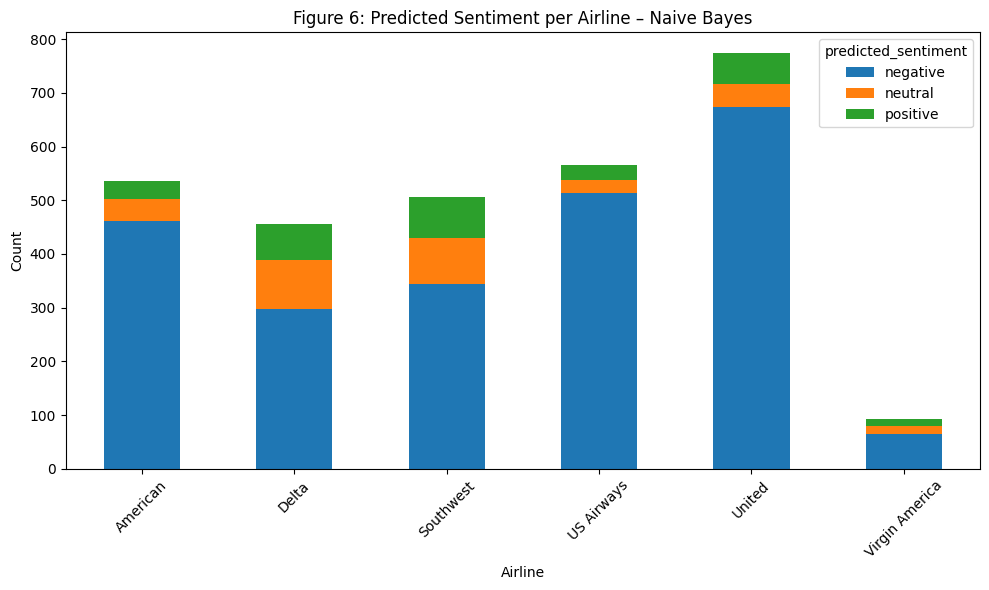

In [8]:
# 7. Airline-level sentiment distribution analysis
X_test_df = X_test.to_frame()
X_test_df['true_sentiment'] = y_test.values
X_test_df['predicted_sentiment'] = y_pred_nb
X_test_df['airline'] = df.loc[X_test.index, 'airline'].values

airline_sentiment_nb = (
    X_test_df
    .groupby(['airline', 'predicted_sentiment'])
    .size()
    .unstack(fill_value=0)
)

airline_sentiment_nb.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Figure 6: Predicted Sentiment per Airline – Naive Bayes")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
labels = ['negative', 'neutral', 'positive']

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

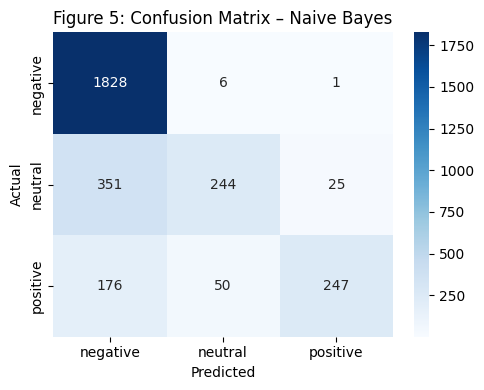

In [10]:
plot_confusion_matrix(y_test, y_pred_nb, "Figure 5: Confusion Matrix – Naive Bayes")